In [1]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker_original
from tqdm import tqdm
import os 
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import torchattacks as ta
import pandas as pd

In [2]:
conf_yaml = '/workspace/dabs/conf/traffic.yaml'
conf_dataset_yaml = '/workspace/dabs/conf/dataset/traffic_sign_small.yaml'
conf_model_yaml = '/workspace/dabs/conf/model/traffic_model.yaml'
ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.001/model.ckpt'
systemClass = viewmaker_original.TrafficViewMaker
batch_size = 32

In [3]:
print('loading config...')
config = OmegaConf.load(conf_yaml)
config.dataset = OmegaConf.load(conf_dataset_yaml)
config.model = OmegaConf.load(conf_model_yaml)
config.dataset.batch_size = batch_size
config.debug = True
pl.seed_everything(config.trainer.seed)

print('loading VM...')
if 'model.ckpt' in ckpt:
    system = torch.load(ckpt)
else:
    system = systemClass(config)
    system.setup('')
    system.load_state_dict(torch.load(ckpt)['state_dict'],strict=False)

system.cuda()
system.eval()




Global seed set to 0


loading config...
loading VM...


TrafficViewMaker(
  (model): TrafficModel(
    (embed_modules): ModuleList()
    (traffic_model): Net(
      (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_drop): Dropout2d(p=0.5, inplace=False)
      (fc1): Linear(in_features=1000, out_features=350, bias=True)
      (fc2): Linear(in_features=350, out_features=43, bias=True)
      (localization): Sequential(
        (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
        (3): Conv2

In [4]:
class_names = [str(i) for i in range(43)] # map between label index and class name
   
from types import MethodType
def forward_original(self, x):
    # transform the input
    x = self.stn(x)

    # Perform forward pass
    x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
    x = self.conv_drop(x)
    x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
    x = self.conv_drop(x)
    x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
    x = self.conv_drop(x)
    x = x.view(-1, 250*2*2)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

system.model.traffic_model.forward = MethodType(forward_original, system.model.traffic_model)
threat_model  = system.model.traffic_model
# state_dict = torch.load('/workspace/gtsrb_pytorch/model_no_aug.pth')
# threat_model.load_state_dict(state_dict)
# threat_model.eval()

# from torchvision import datasets, transforms
# from gtsrb_pytorch.data import *
# loader = val_loader = torch.utils.data.DataLoader(datasets.ImageFolder('/workspace/gtsrb_pytorch/data/val_images',transform=data_transforms), batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
MEAN,STD = np.array([0.3337, 0.3064, 0.3171],dtype=np.float32), np.array([ 0.2672, 0.2564, 0.2629],dtype=np.float32)
class_names = [str(i) for i in range(43)] # map between label index and class name

In [31]:
pl.seed_everything(123654)


df_dict = {
    "label" : [],
    "pred" : [],
    "adv_pred": []
}
num_views = 3

loaders = [system.train_dataloader(), system.val_dataloader()]

# VM
# for loader in loaders:
#     for index , img , labels in tqdm(loader):
#         with torch.no_grad():
#             img = img.cuda()
#             for i in range(num_views):
#                 views1, _ = system.view(img, True)
#                 pred = threat_model(system.normalize(img)).argmax(1, keepdim = True)
#                 adv_pred = threat_model(views1).argmax(1, keepdim = True)

#                 df_dict['label'].append(labels.unsqueeze(-1).cpu())
#                 df_dict['pred'].append(pred.cpu())
#                 df_dict['adv_pred'].append(adv_pred.cpu())

# FGSM
num_views = 1
# atk = ta.FGSM(threat_model, eps=0.001)
atk = ta.PGD(threat_model, eps=0.035, alpha=0.035/8, steps=10)
atk.set_normalization_used(mean=MEAN, std=STD)
for loader in loaders:
    for index , img , labels in tqdm(loader):
        # with torch.no_grad():
        img = img.cuda()
        for i in range(num_views):
            # views1, _ = system.view(img, True)
            views1 = atk(system.normalize(img),labels)
            pred = threat_model(system.normalize(img)).argmax(1, keepdim = True)
            adv_pred = threat_model(views1).argmax(1, keepdim = True)

            df_dict['label'].append(labels.unsqueeze(-1).cpu())
            df_dict['pred'].append(pred.cpu())
            df_dict['adv_pred'].append(adv_pred.cpu())


df_dict['label'] = torch.vstack(df_dict['label']).squeeze().numpy()
df_dict['pred'] = torch.vstack(df_dict['pred']).squeeze().numpy()
df_dict['adv_pred'] = torch.vstack(df_dict['adv_pred']).squeeze().numpy()

df = pd.DataFrame.from_dict(df_dict)


Global seed set to 123654
100%|██████████| 61/61 [00:03<00:00, 16.42it/s]


In [36]:
acc = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_001 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_005 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_035 = (df['pred'] == df['adv_pred']).mean()

In [33]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')

In [26]:
# cf_matrix_0_035 = cf_matrix
# cf_matrix_0_005 = cf_matrix
cf_matrix_0_001 = cf_matrix

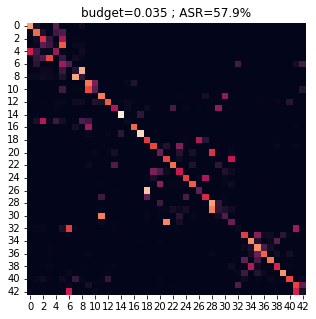

In [37]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix,cbar=False)#, annot=True, fmt='.2f')
plt.title(f'budget=0.035 ; ASR={(1-acc)*100:.1f}%')
plt.show()

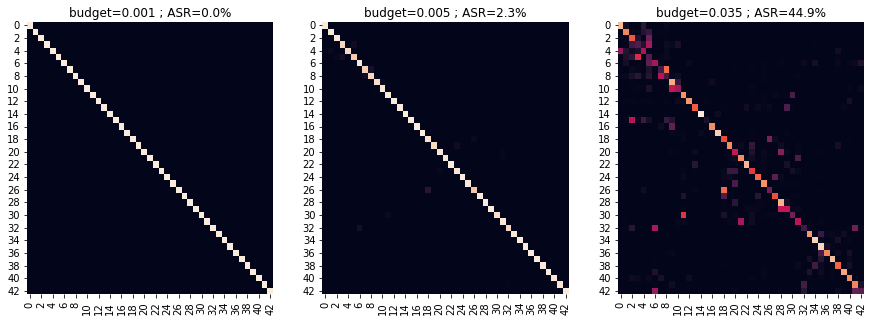

In [30]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix_0_001,cbar=False,ax=ax[0])#, annot=True, fmt='.2f')
ax[0].set_title(f'budget=0.001 ; ASR={(1-adv_acc_0_001)*100:.1f}%')
sns.heatmap(cf_matrix_0_005,cbar=False,ax=ax[1])#, annot=True, fmt='.2f')
ax[1].set_title(f'budget=0.005 ; ASR={(1-adv_acc_0_005)*100:.1f}%')
sns.heatmap(cf_matrix_0_035,cbar=False,ax=ax[2])#, annot=True, fmt='.2f')
ax[2].set_title(f'budget=0.035 ; ASR={(1-adv_acc_0_035)*100:.1f}%')
plt.show()